In [13]:
# Imports
import matplotlib.pyplot as plt   
import pandas as pd
import numpy as np


### Loading data

In [14]:
df = pd.read_csv('Pima Indians Diabetes Database.csv')

# Display the first few rows of the dataframe
print(df.head())
print(df.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

## Decide on features

In [15]:
X = df[['Age', 'BMI', 'BloodPressure']]
y = df['Outcome']

              Age         BMI  BloodPressure
count  768.000000  768.000000     768.000000
mean    33.240885   31.992578      69.105469
std     11.760232    7.884160      19.355807
min     21.000000    0.000000       0.000000
25%     24.000000   27.300000      62.000000
50%     29.000000   32.000000      72.000000
75%     41.000000   36.600000      80.000000
max     81.000000   67.100000     122.000000
Lower bounds for outliers:
 Age              -1.50
BMI              13.35
BloodPressure    35.00
dtype: float64
Upper bounds for outliers:
 Age               66.50
BMI               50.55
BloodPressure    107.00
dtype: float64


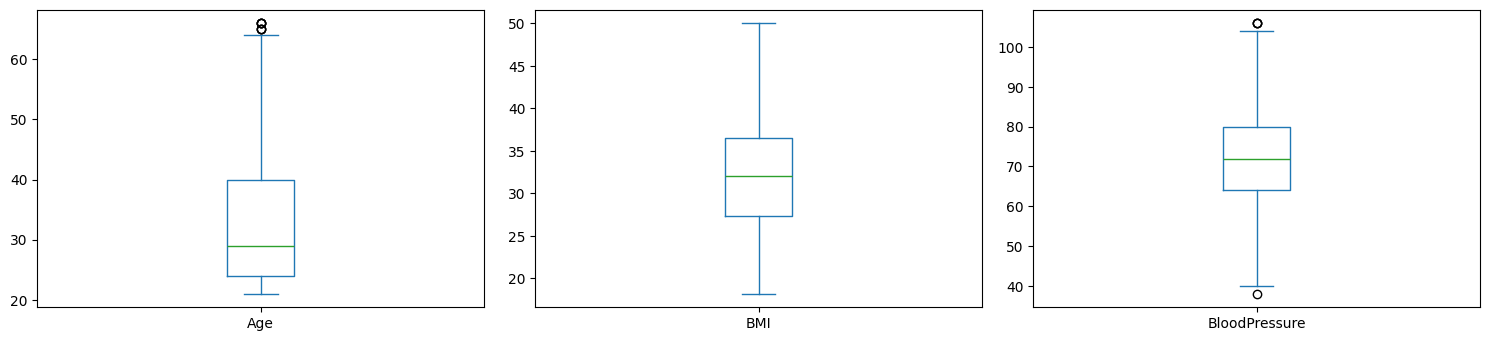

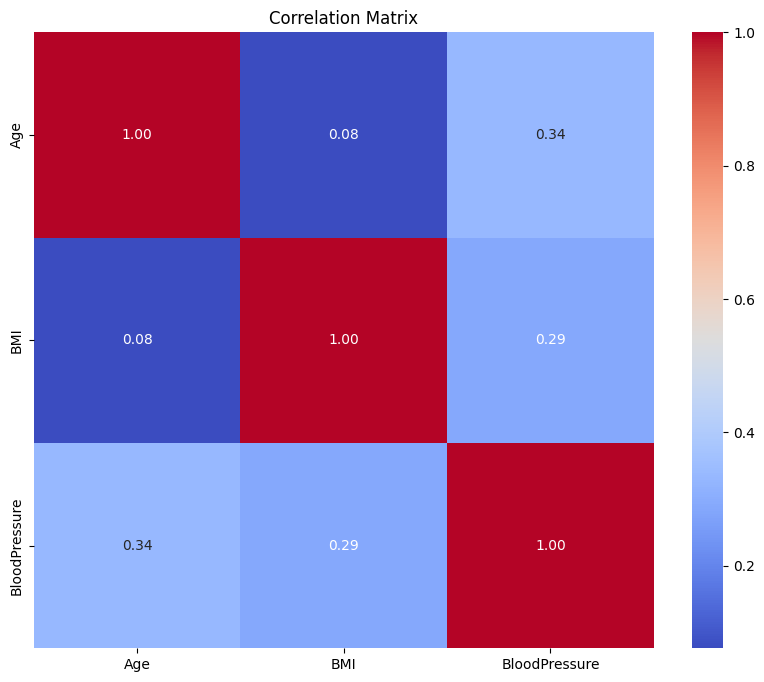

In [16]:
# print the quartile values for all numerical features 
print(X.describe())
# for each column, save the IQR, as well as the lower and upper bounds for outliers
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Lower bounds for outliers:\n", lower_bound)
print("Upper bounds for outliers:\n", upper_bound)
# remove all outliers from the dataframe based on these data
X = X[(X >= lower_bound) & (X <= upper_bound)]

# show box plots of all numerical features
X.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,10))
plt.tight_layout()
plt.show()
import seaborn as sns   
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

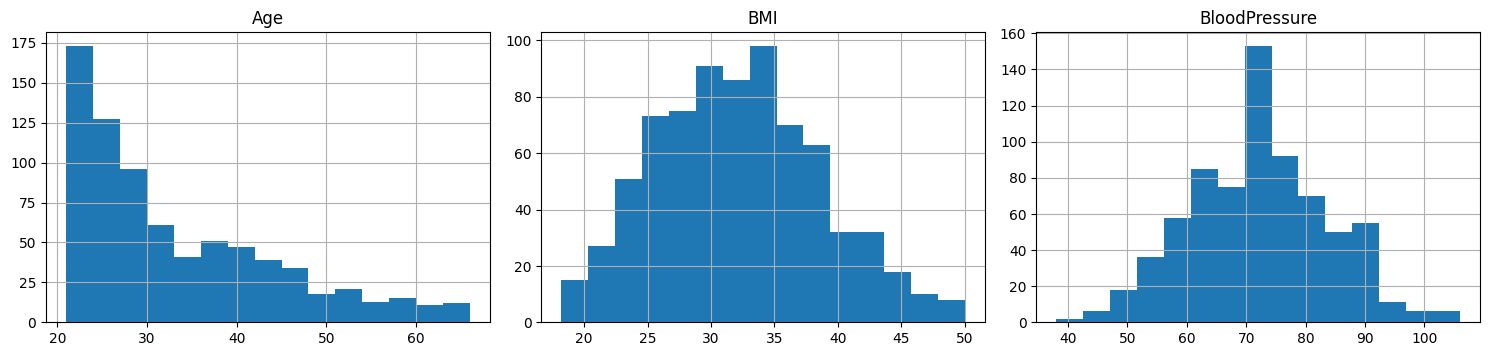

In [17]:
# print the histograms of all numerical features
X.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

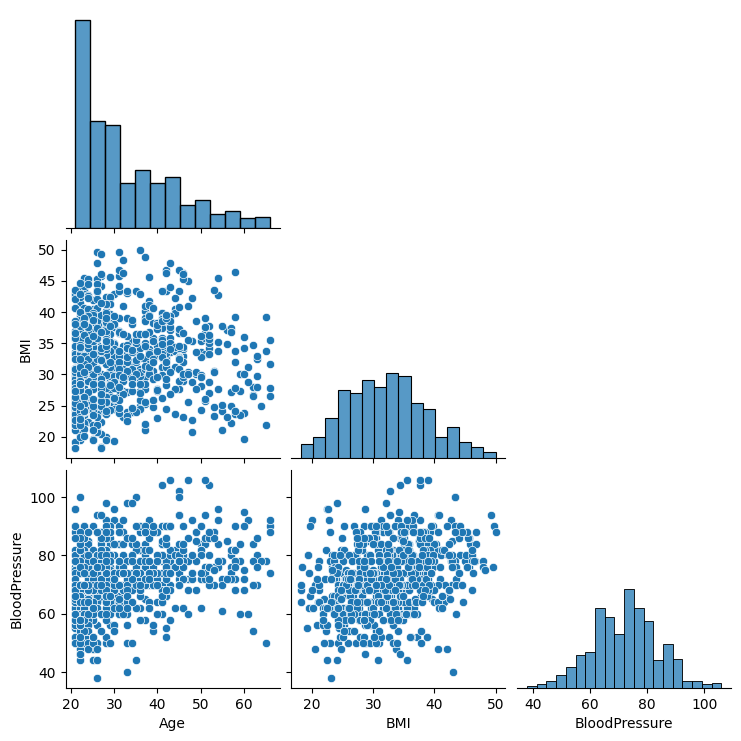

In [18]:



# do a paitplot of all numerical features
sns.pairplot(X,
             corner=True
             )
plt.show()

In [19]:

# show all examples with any missing values
print(df[df.isnull().any(axis=1)])


Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


## Feature selection

To invasive / can't be measured easily: Glucose, Insulin, Skin Thickness
DPF: Hard to determine, would also require to reveal family history
Number of pregnancies: Difficult, because only women affected, possibly a touchy subject

Leaves: 
Age: Is not discriminating, but just a fact
BMI: If self-reported, same
Blood pressure: Easy to measure and a regular accepted measure

# Feature Engineering

Age: Logarithminc is not the right approach here, as the imbalance is simply an underrepresentation of older people. A better approach may be upsampling as to not lose information, or even not do anything at all. 
BMI: No engineering required
Blood Pressure: same

### Check missing features


In [20]:
# check for missing features
print(X.isnull().sum())
# Check the number of examples that have at least one missing value
print("Number of examples with missing values:", X.isnull().any(axis=1).sum())
# check the total number of examples
print("Total number of examples:", X.shape[0])
X = X.dropna()
y = y[X.index]
print("Number of examples after removing missing values:", X.shape[0])

Age               9
BMI              19
BloodPressure    45
dtype: int64
Number of examples with missing values: 61
Total number of examples: 768
Number of examples after removing missing values: 707


## Because there are clear correlations between the remaining features, a PCA dimensionality reduction may make sense

Explained variance ratio: [0.4919046  0.31508355 0.19301185]


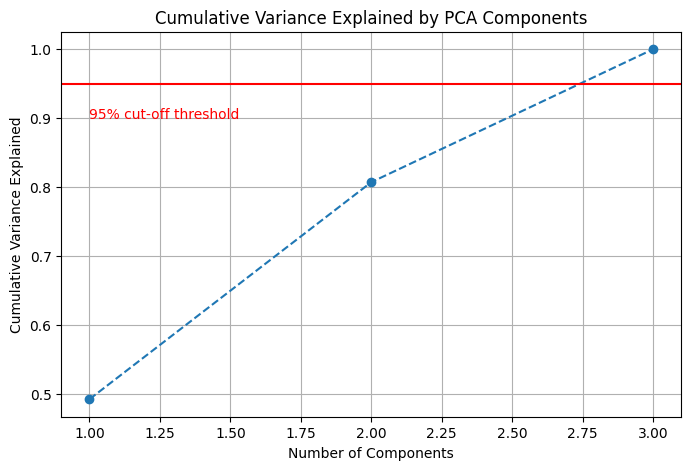

In [21]:
# do a PCA of scaled X and plot the feature contributions in % of variance explained
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler   
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
# Print the explained variance ratio
print("Explained variance ratio:", explained_variance)
# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance)
# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(1, 0.90, '95% cut-off threshold', color = 'red', fontsize=10)
plt.show()



Result: Keep all 3 features. 

# Model training


## Test set

In [30]:
X_test = X.sample(frac=0.2, random_state=0) # 20% for testing
X_train = X.drop(X_test.index)
y_test = y[X_test.index]
y_train = y[X_train.index]

## Logistic Regression Model

Precision scores: [0.44615385 0.5        0.56603774 0.525      0.54166667]
Recall scores: [0.76315789 0.69230769 0.76923077 0.6        0.63414634]
ROC AUC scores: [0.68247922 0.72765073 0.77200277 0.77728938 0.71883469]
Mean Recall: 0.6918 ± 0.0676
Accuracy: 0.6383
Precision: 0.4896
Recall: 0.9592
F1-score: 0.6483
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.47      0.63        92
           1       0.49      0.96      0.65        49

    accuracy                           0.64       141
   macro avg       0.72      0.71      0.64       141
weighted avg       0.79      0.64      0.63       141

Confusion matrix:
 [[43 49]
 [ 2 47]]


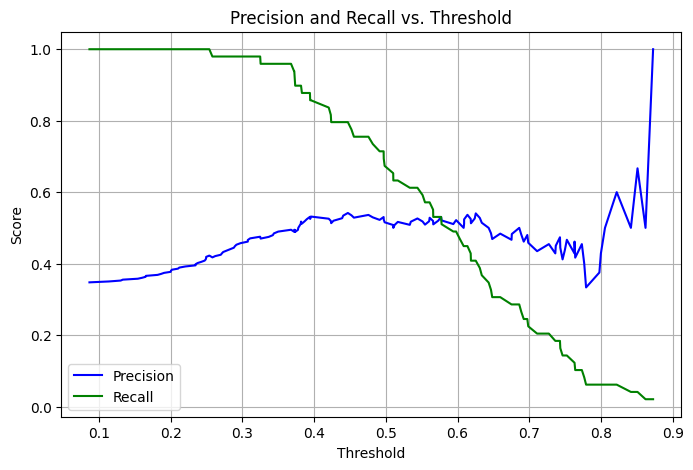

In [68]:
# Train a logistic regression model with default parameters. Use validation datasets and do 5-fold cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Initialize model
lr = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', max_iter=1000))

# Setup K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Use cross_validate with multiple scoring metrics
scores = cross_validate(
    lr,
    X_train,
    y_train,
    cv=kf,
    scoring=['precision', 'recall', 'roc_auc'],  # Adjusted for multi-class
    return_train_score=False
)

# Print results
print("Precision scores:", scores['test_precision'])
print("Recall scores:", scores['test_recall'])
print("ROC AUC scores:", scores['test_roc_auc'])

mean_recall = np.mean(scores['test_recall'])
std_recall = np.std(scores['test_recall'])
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")

# # Fit the model on the entire training set and evaluate on the test set
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
# print("Classification report:\n", classification_report(y_test, y_pred))
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))  

# # Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")

# Predict probabilities
y_probs = lr.predict_proba(X_test)[:, 1]

# Set custom threshold (e.g., 0.3 instead of 0.5)
threshold = 0.35
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate recall
# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_custom))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom))

# Plot a graph that sows the threshold on the x axis and the recall and precision on the y axis
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()


It's important to have a high recall, i.e. to catch as many true cases of diabetes early. Precision is not so much of a concern, as there would quickly be a negative actual test. 

Other than the class weight it is justified to lower the decision threshold to 0.35 as there the recall is very high, while the precision is at 50%, meaning that every second test is a false positive. However, as this is a risk identifier, rather than a diagnosis, this may be justified.

Decision Tree Precision scores: [0.46875    0.41176471 0.4047619  0.40909091 0.53846154]
Decision Tree Recall scores: [0.39473684 0.35897436 0.43589744 0.51428571 0.51219512]
Decision Tree ROC AUC scores: [0.58552632 0.54435204 0.5490298  0.59230769 0.63109756]
Decision Tree Mean Recall: 0.4432 ± 0.0621
Accuracy: 0.6596
Precision: 0.5106
Recall: 0.4898
F1-score: 0.5000
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74        92
           1       0.51      0.49      0.50        49

    accuracy                           0.66       141
   macro avg       0.62      0.62      0.62       141
weighted avg       0.66      0.66      0.66       141

Confusion matrix:
 [[69 23]
 [25 24]]


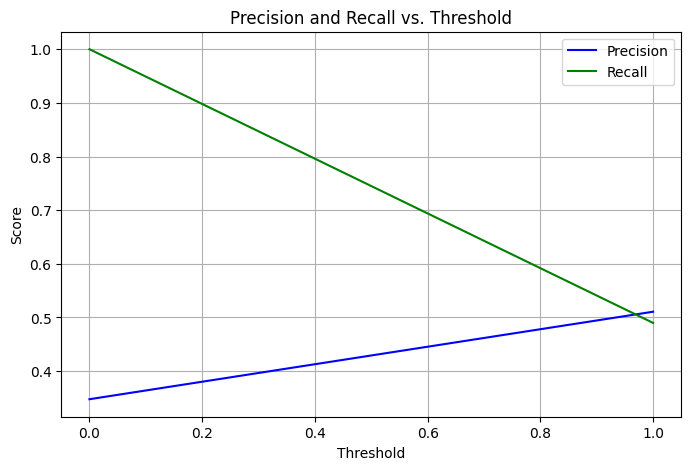

In [73]:
# Now train a DecisionTree model with 5 fold CV
from sklearn.tree import DecisionTreeClassifier
# Initialize model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)    
# Use cross_validate with multiple scoring metrics
scores_dt = cross_validate(
    dt,
    X_train,
    y_train,
    cv=kf,
    scoring=['precision', 'recall', 'roc_auc'],  # Adjusted for multi-class
    return_train_score=False
)   
# Print results
print("Decision Tree Precision scores:", scores_dt['test_precision'])
print("Decision Tree Recall scores:", scores_dt['test_recall'])
print("Decision Tree ROC AUC scores:", scores_dt['test_roc_auc'])
mean_recall_dt = np.mean(scores_dt['test_recall'])
std_recall_dt = np.std(scores_dt['test_recall'])
print(f"Decision Tree Mean Recall: {mean_recall_dt:.4f} ± {std_recall_dt:.4f}")
# Fit the model on the entire training set and evaluate on the test set
dt.fit(X_train, y_train)

# Predict probabilities
y_probs = dt.predict_proba(X_test)[:, 1]

# Set custom threshold (e.g., 0.3 instead of 0.5)
threshold = 0.1
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate recall
# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_custom))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom))

# Plot a graph that sows the threshold on the x axis and the recall and precision on the y axis
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()


Random Forest Precision scores: [0.48648649 0.46153846 0.51851852 0.44444444 0.66666667]
Random Forest Recall scores: [0.47368421 0.30769231 0.35897436 0.34285714 0.3902439 ]
Random Forest ROC AUC scores: [0.7098338  0.67862093 0.68503119 0.69688645 0.72120596]
Random Forest Mean Recall: 0.3747 ± 0.0562
Accuracy: 0.5319
Precision: 0.4234
Recall: 0.9592
F1-score: 0.5875
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.30      0.46        92
           1       0.42      0.96      0.59        49

    accuracy                           0.53       141
   macro avg       0.68      0.63      0.52       141
weighted avg       0.76      0.53      0.50       141

Confusion matrix:
 [[28 64]
 [ 2 47]]


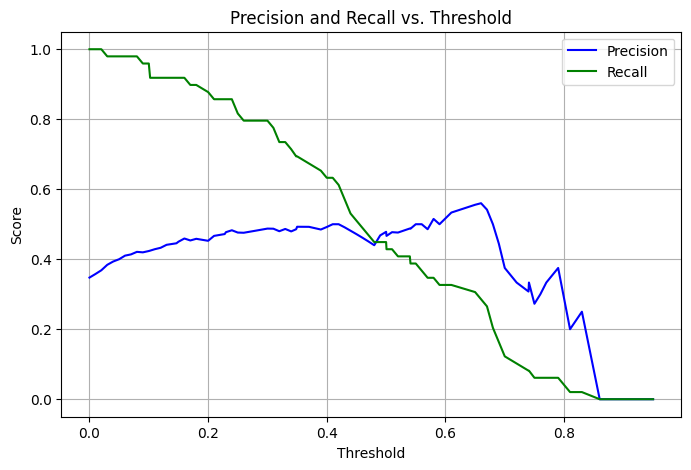

In [71]:
# Now train a 5 fold cross validated random forest model on the entire training set     
from sklearn.ensemble import RandomForestClassifier
# Initialize model
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
# Use cross_validate with multiple scoring metrics
scores_rf = cross_validate(
    rf,
    X_train,
    y_train,
    cv=kf,
    scoring=['precision', 'recall', 'roc_auc'],  # Adjusted for multi-class
    return_train_score=False
)
# Print results
print("Random Forest Precision scores:", scores_rf['test_precision'])
print("Random Forest Recall scores:", scores_rf['test_recall'])
print("Random Forest ROC AUC scores:", scores_rf['test_roc_auc'])
mean_recall_rf = np.mean(scores_rf['test_recall'])
std_recall_rf = np.std(scores_rf['test_recall'])
print(f"Random Forest Mean Recall: {mean_recall_rf:.4f} ± {std_recall_rf:.4f}")
# Fit the model on the entire training set and evaluate on the test set
rf.fit(X_train, y_train)
# Predict probabilities
y_probs = rf.predict_proba(X_test)[:, 1]

# Set custom threshold (e.g., 0.3 instead of 0.5)
threshold = 0.1
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate recall
# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_custom))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom))

# Plot a graph that sows the threshold on the x axis and the recall and precision on the y axis
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()
